In [1]:
import os
import time
import cv2
import numpy as np
import requests as req
import IPython
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from utils import show_image
from IPython.display import clear_output

In [2]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [4]:
tf.__version__

'2.4.0-rc1'

In [5]:
%matplotlib inline

Load the saved model, trained using a pre-trained model on a different dataset.

In [7]:
print("Loading model...")
start_time = time.time()
detect_fn = tf.saved_model.load('../exported-models/ssd_mobilenet_v2/saved_model')
print('Loading took {} seconds.'.format(time.time()-start_time))

Loading model...
Loading took 55.066099882125854 seconds.


Load model labels

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(
    '../annotations/label_map.pbtxt', 
    use_display_name=True
)

Do inference

In [15]:
#URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2580261' # 'LIVE' inference.
URL = 'https://www.vegvesen.no/public/webkamera/kamera?id=2992499'

In [16]:
def get_image(url, flags=cv2.IMREAD_COLOR):
    try:
        r = req.get(url)
        if r.status_code != 200: # Is the camera down?
            return None
        img = cv2.imdecode(np.frombuffer(r.content, dtype=np.uint8), flags)
        img = img[25:,:,:] # Crop away the top black bar.
        return img
    except:
        print("Response timed out!")
        return None

def inference(image_np, input_tensor, visualize_img=False):
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    start_time = time.time()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=0.4,
        agnostic_mode=False,
        line_thickness=1,
        mask_alpha=0.4
    )
    print('Inference took {} seconds'.format(time.time()-start_time))
    if visualize_img:
        show_image(image_np, size=(16,12))
        
def inference_url(url, visualize_img=False):
    img = get_image(url)
    if img is None:
        return
    inference(img, tf.convert_to_tensor(img), visualize_img)

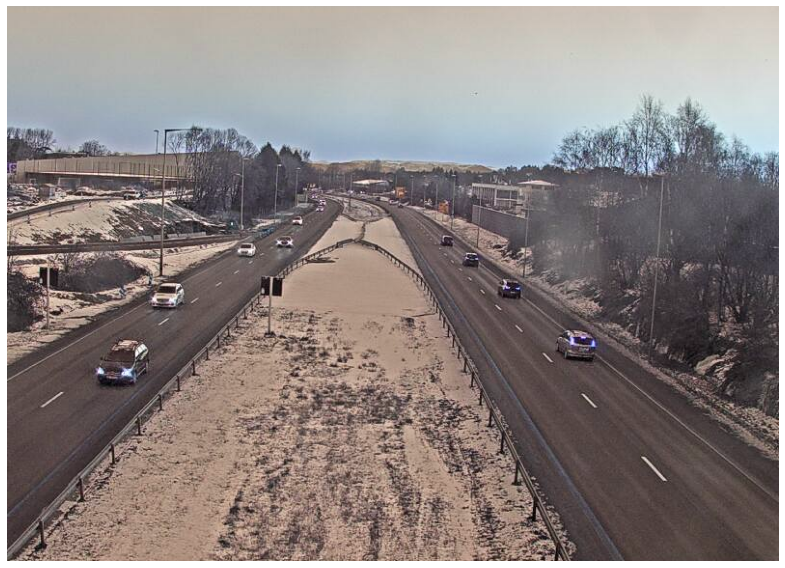

In [11]:
# Test
show_image(get_image(URL))

Inference took 0.0 seconds


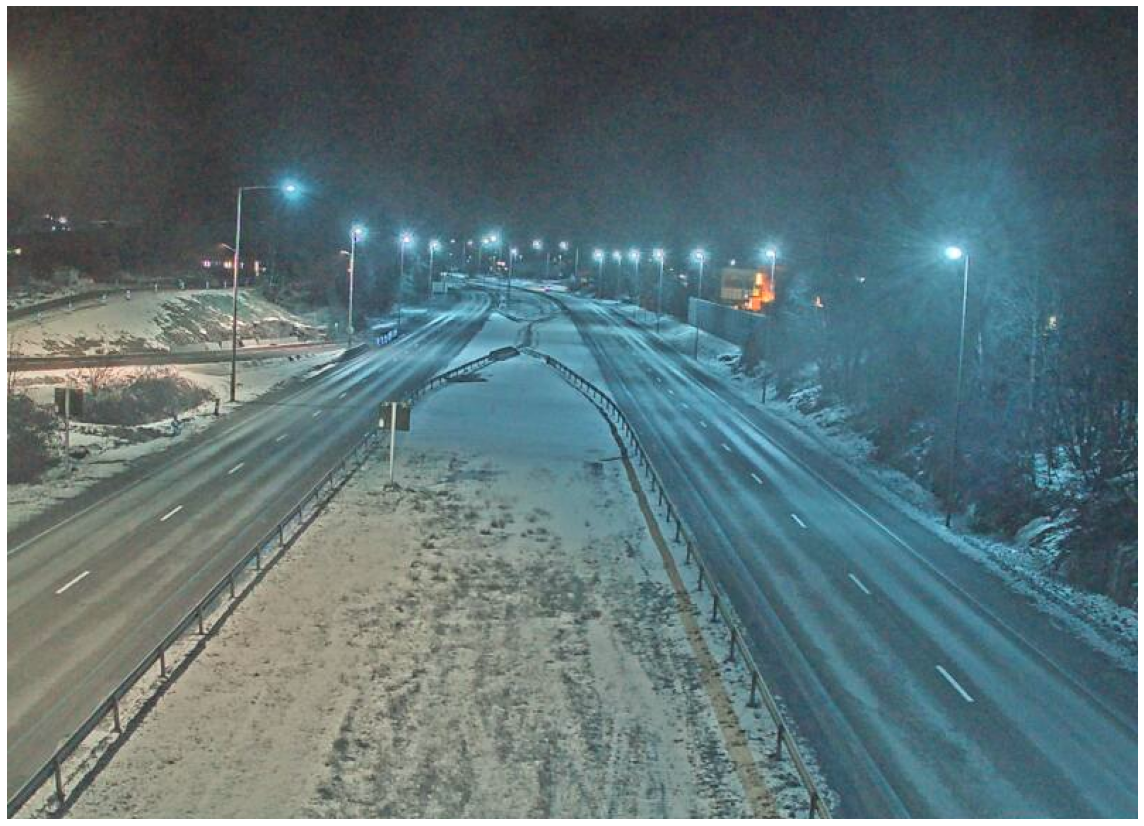

In [85]:
inference_url(URL, True)

Inference took 0.039002180099487305 seconds


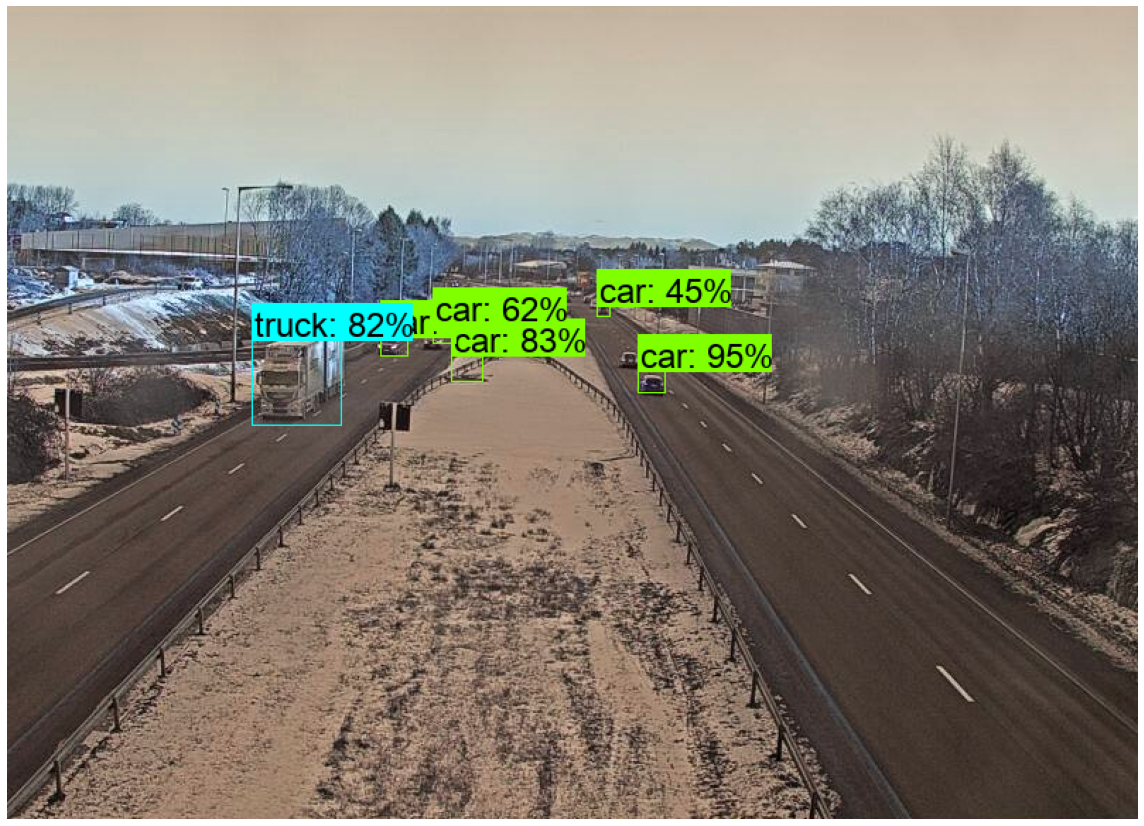

In [45]:
inference_url(URL, True)

Inference took 0.0060002803802490234 seconds


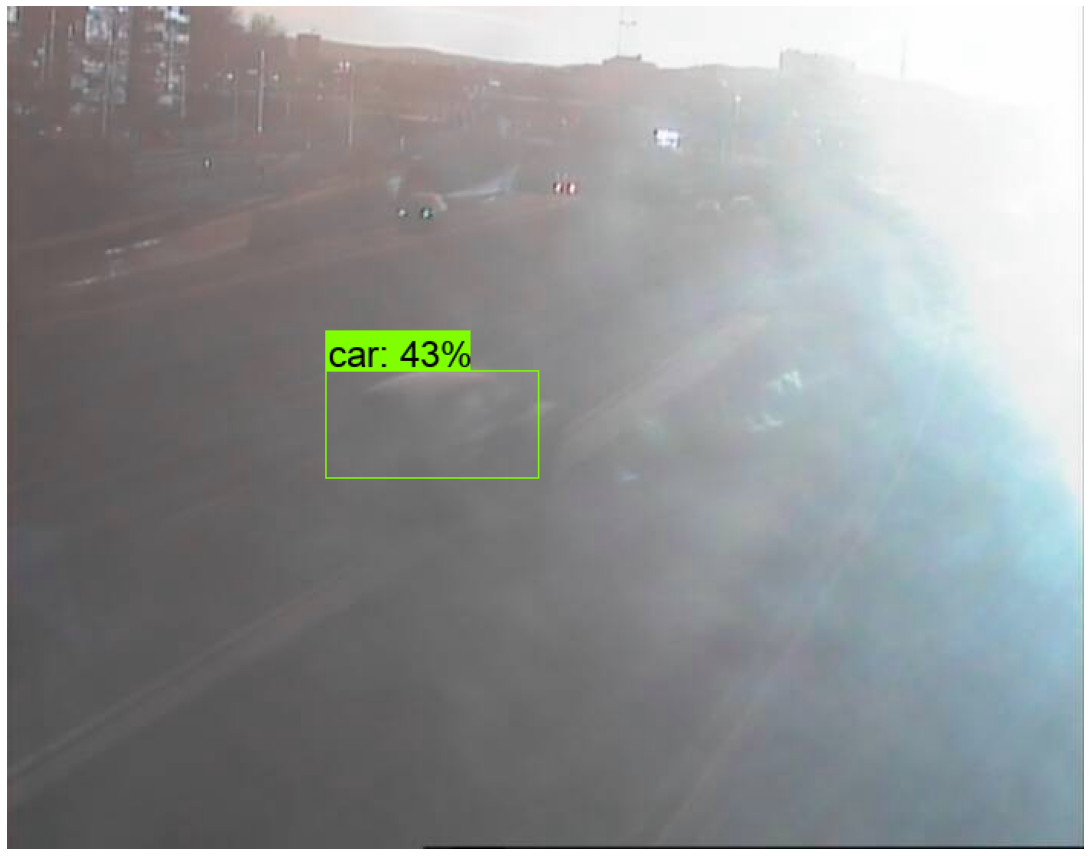

In [46]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=297619', True)

Inference took 0.0 seconds


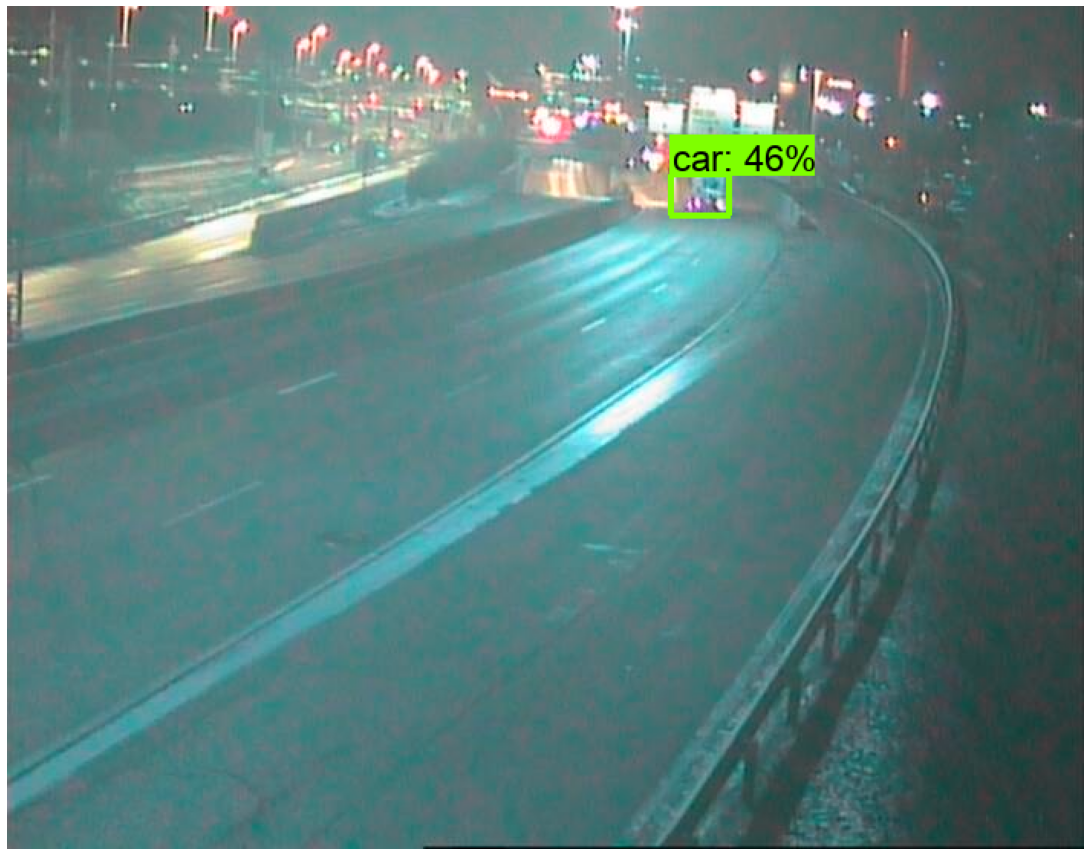

In [40]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=297619', True)

Inference took 0.020000219345092773 seconds


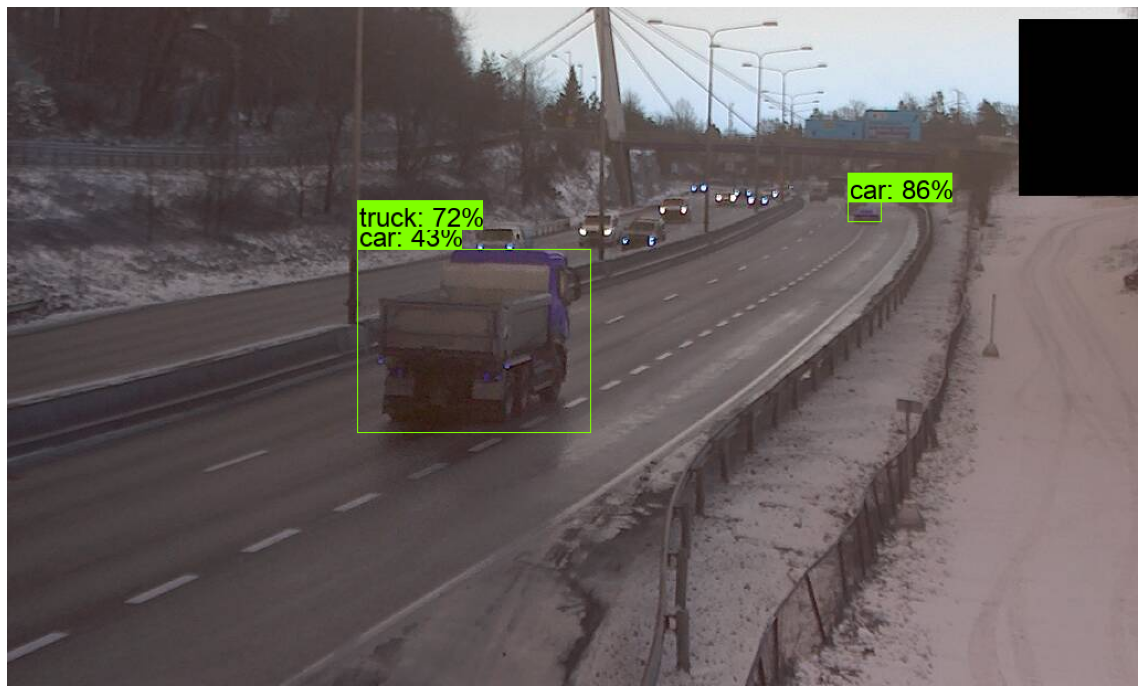

In [42]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=640748', True)

Inference took 0.007000446319580078 seconds


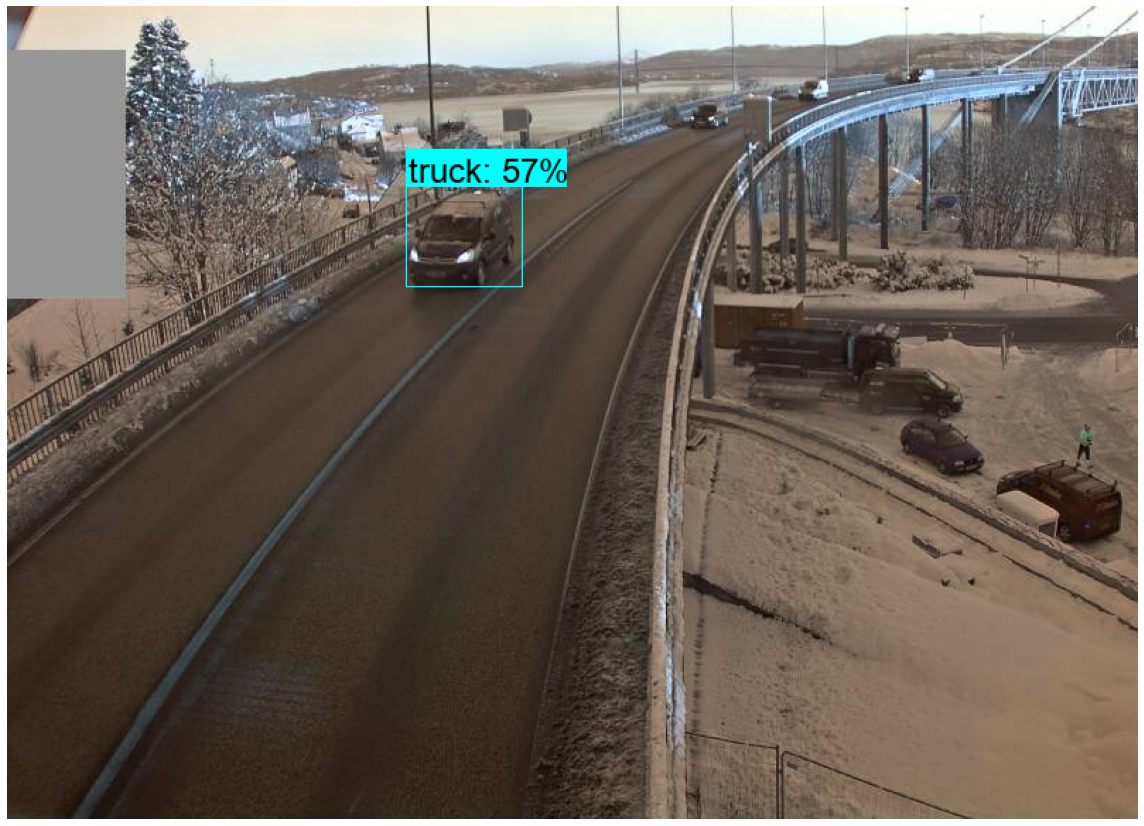

In [49]:
inference_url('https://www.vegvesen.no/public/webkamera/kamera?id=1592263', True)

In [33]:
STREAM = 'https://kamera.vegvesen.no/public/0329001_1/hls_1_stream_1_orig.m3u8'

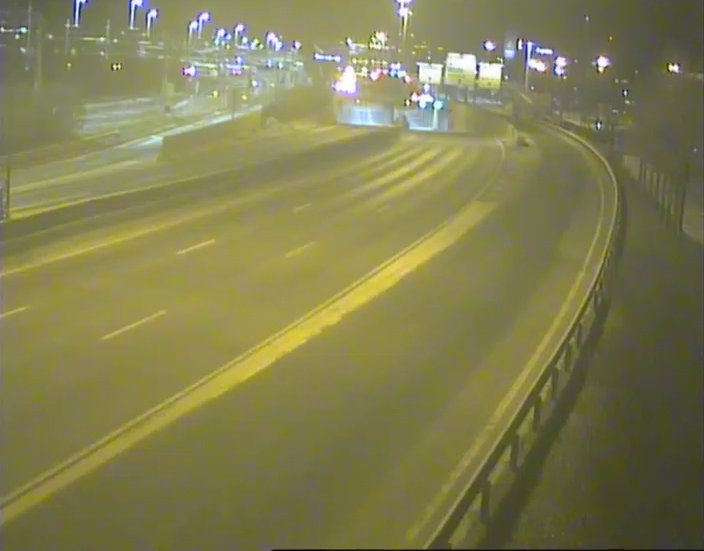

Stopped Video Stream


In [7]:
vstream = None
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            clear_output(wait=True)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame[25:,:,:] # Crop away the top black bar.
            inference(frame, tf.convert_to_tensor(frame), False)
            IPython.display.display(Image.fromarray(frame))
        time.sleep(2)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Noise removal, region cropping, etc.

In [36]:
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
fgbg

<BackgroundSubtractorMOG2 0000000019F9BCB0>

In [52]:
vstream = None
fg = None
bg = None
cnt = 0
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture('https://kamera.vegvesen.no/public/1129024_1/hls_1_stream_1_orig.m3u8')
    while True:
        ret, frame = vstream.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame[155:, :-250, :] # Region Cropping.
            bg = frame
            fg = fgbg.apply(frame)
            cnt += 1
            print('Processed Frame', cnt)
        time.sleep(0.25)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Started Video Stream
Processed Frame 1
Processed Frame 2
Processed Frame 3
Processed Frame 4
Processed Frame 5
Processed Frame 6
Processed Frame 7
Processed Frame 8
Processed Frame 9
Processed Frame 10
Processed Frame 11
Processed Frame 12
Processed Frame 13
Processed Frame 14
Processed Frame 15
Processed Frame 16
Processed Frame 17
Processed Frame 18
Processed Frame 19
Processed Frame 20
Processed Frame 21
Processed Frame 22
Processed Frame 23
Processed Frame 24
Processed Frame 25
Processed Frame 26
Processed Frame 27
Processed Frame 28
Processed Frame 29
Processed Frame 30
Processed Frame 31
Processed Frame 32
Processed Frame 33
Processed Frame 34
Processed Frame 35
Processed Frame 36
Processed Frame 37
Processed Frame 38
Processed Frame 39
Processed Frame 40
Processed Frame 41
Stopped Video Stream


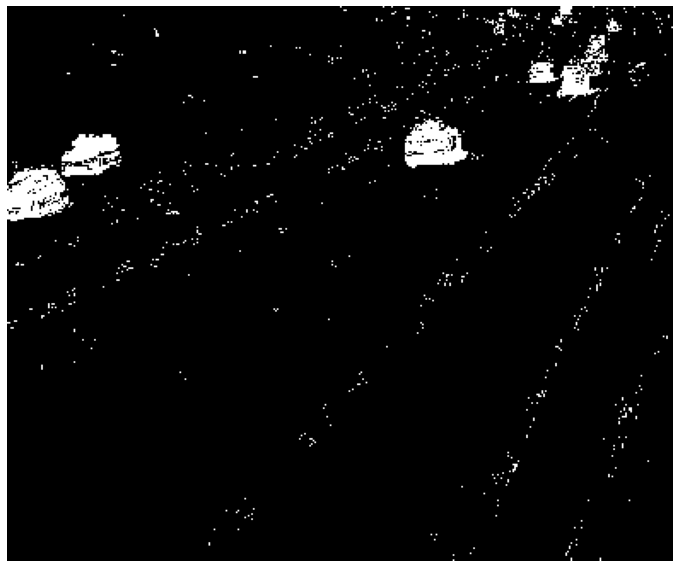

In [56]:
show_image(fg, grayscale=True)

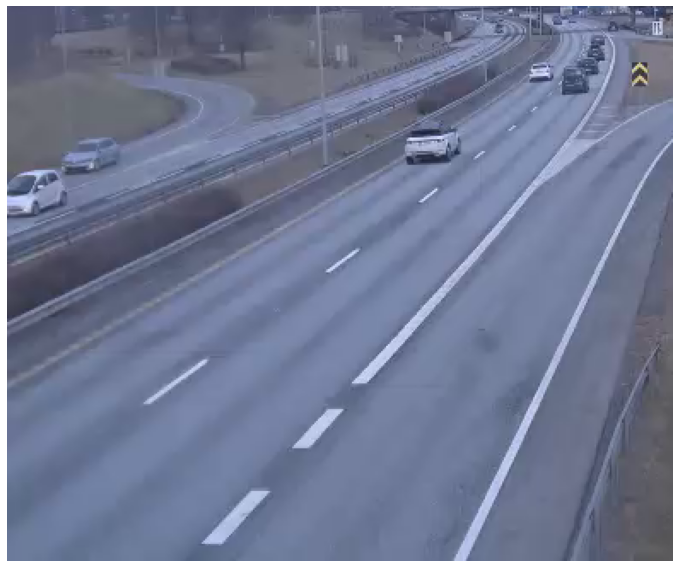

In [57]:
show_image(bg)

In [63]:
I = bg.copy()
for row, p in enumerate(fg):
    for col, v in enumerate(p):
        if v == 0:
            I[row, col, :] = 0

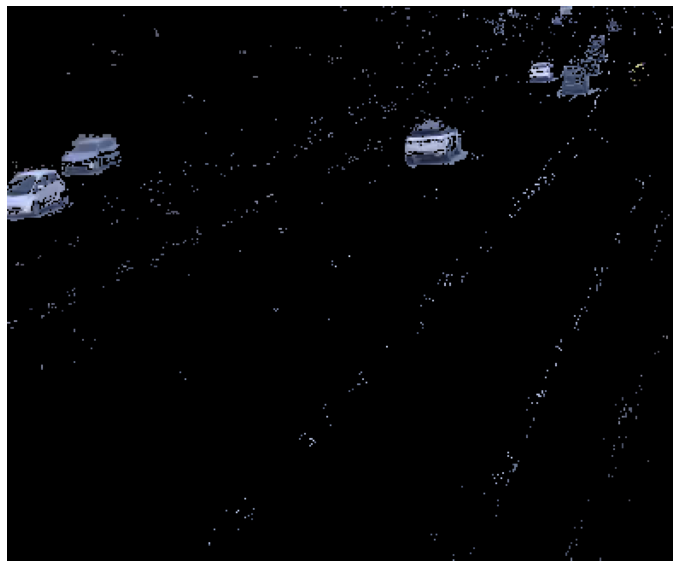

In [67]:
show_image(I)